In [51]:
# load packages
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelahuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/angelahuo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Project Overview

* The second notebook will conduct a linguistic and thematic analysis of the New York Times Hardcover Fiction bestsellers dataset. While the first notebook explored who dominates the bestseller list (authors, books, publishers, seasons) and conducted a general pattern analysis, this notebook asks the question: $\textbf{What content dominates the NYT bestselling market?}$

* Specifically, we will utilize natural language processing (NLP) tools in order to determine the topics, themes, and sentiments in book descriptions that are more likely to become NYT bestsellers.

# Load Data

In [52]:
# load previously cleaned data
DATA_PATH = os.path.join('..','..', 'data','analysis','bestsellers_analysis_ready.csv')
df = pd.read_csv(DATA_PATH)
print('Shape of original df:', df.shape)

# remove duplicate isbn13 entries for analysis
unique_df = df.drop_duplicates(subset="isbn13").copy()
print('Shape of unique df:', unique_df.shape)

unique_df.head()

Shape of original df: (5775, 9)
Shape of unique df: (1366, 9)


,list_date,isbn13,rank,weeks_on_list,title,author,publisher,description,month
0,2018-07-15,9780316412698,1,4,THE PRESIDENT IS MISSING,James Patterson and Bill Clinton,"Little, Brown and Knopf",President Jonathan Duncan takes on adversaries...,7
1,2018-07-15,9780399178924,2,1,ALL WE EVER WANTED,Emily Giffin,Ballantine,A scandal sends members of two Nashville famil...,7
2,2018-07-15,9781501180989,3,6,THE OUTSIDER,Stephen King,Scribner,A detective investigates a seemingly wholesome...,7
3,2018-07-15,9780316375269,4,2,THE PERFECT COUPLE,Elin Hilderbrand,"Little, Brown",A body is found in Nantucket Harbor hours befo...,7
4,2018-07-15,9781250161598,5,5,SHELTER IN PLACE,Nora Roberts,St. Martin's,Survivors of a mass shooting outside a mall in...,7


# Data Preprocessing

* We will use SpaCy to preprocess book descriptions over tools such as regex or NLTK because its ability to lemmatize words, reduce noise by eliminating filler words, and tokenize text suits our purpose of identifying thematic patterns, rather than grammatical artifacts.

In [53]:
# preprocess descriptions with spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])

def preprocess(text):
    if pd.isna(text):
        return ''
    text = re.sub(r'[^A-Za-z\s]', ' ', str(text))
    doc = nlp(text.lower())
    tokens = [t.lemma_ for t in doc if not t.is_stop and not t.is_punct and len(t)>2]
    return ' '.join(tokens)

unique_df["clean_description"] = unique_df["description"].fillna("").apply(preprocess)
unique_df["clean_description"].head()

0    president jonathan duncan take adversary home ...
1           scandal send member nashville family chaos
2    detective investigate seemingly wholesome memb...
3    body find nantucket harbor hour picture perfec...
4    survivor mass shooting outside mall portland d...
Name: clean_description, dtype: object

# NLP Analysis

## 1. Unigram Frequency Analysis

* What are the most common content-bearing words across bestsellers? Let us first take a look at basic unigram frequency. This simple analysis will give us a baseline reference.


In [54]:
stop_words = set(stopwords.words("english"))

# tokenize descriptions
words = []
for text in unique_df["clean_description"]:
    words.extend([
        w for w in text.split()
        if w not in stop_words and len(w) > 2
    ])

# frequency count
word_counts = Counter(words)
common_words = word_counts.most_common(15)

# dataframe for visualization
freq_df = pd.DataFrame(common_words, columns=["word", "count"])
freq_df

,word,count
0,book,398
1,series,387
2,woman,138
3,family,126
4,new,98
5,year,93
6,life,92
7,murder,85
8,war,79
9,find,76


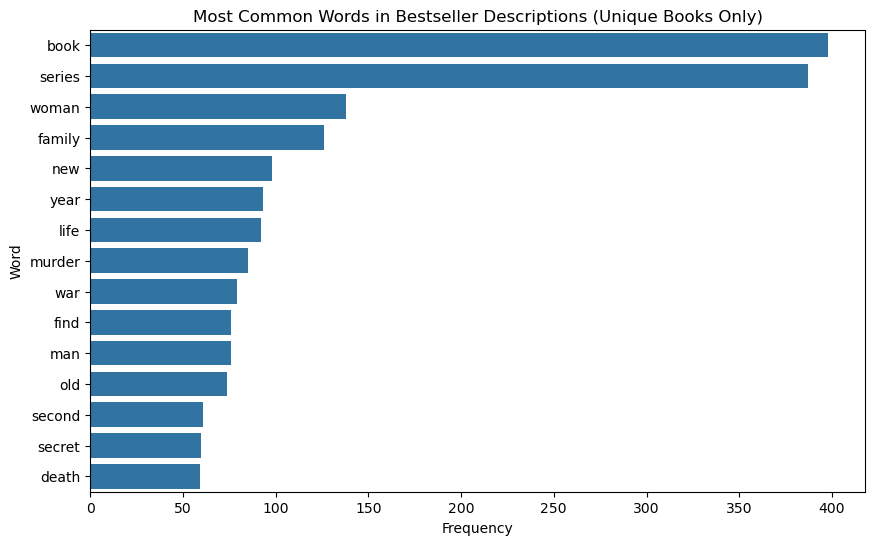

In [55]:
# visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=freq_df, y="word", x="count")
plt.title("Most Common Words in Bestseller Descriptions (Unique Books Only)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

* Generic words like book and series dominate the list as expected. These words do not provide much insight into deeper thematic patterns so later, I will visualize the frequency list with these words removed. However, I decided to keep these words in my analysis because they indicate the prevalence of series fiction among bestsellers.

* "Woman" is almost twice as frequent as "man" in these bestseller descriptions, which aligns with the rise in female-led and oriented commercial fiction.

* We already see strong themes like family, murder, war,and death.

## 2. Bigram Frequency Analysis

* Then, to Identify repeated phrases that offer deeper thematic or stylistic signals, we will conduct a bigram frequency analysis. This allows word context to be factored into our analysis.

In [56]:
bigram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),
    stop_words="english",
    min_df=3
)

X_bigram = bigram_vectorizer.fit_transform(unique_df["clean_description"])

# count bigram frequencies
bigram_freq = np.array(X_bigram.sum(axis=0)).flatten()
bigram_terms = bigram_vectorizer.get_feature_names_out()

# convert to dataframe for plotting
bigram_df = pd.DataFrame({
    "bigram": bigram_terms,
    "count": bigram_freq
}).sort_values("count", ascending=False).head(15)

bigram_df

,bigram,count
273,second book,54
357,year old,33
219,new york,25
353,world war,19
361,young woman,17
148,fourth book,16
171,jack ryan,16
278,serial killer,16
132,eve dallas,15
143,fifth book,15


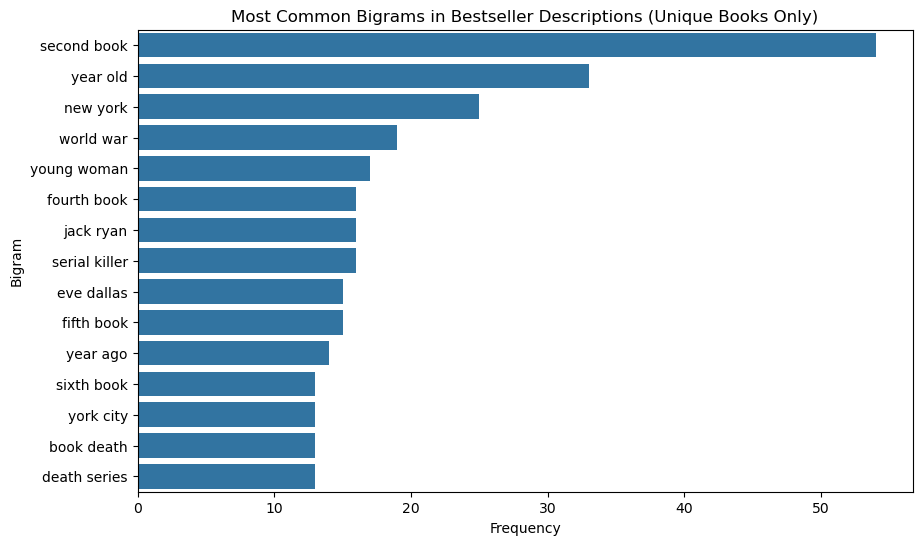

In [57]:
# visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=bigram_df, y="bigram", x="count")
plt.title("Most Common Bigrams in Bestseller Descriptions (Unique Books Only)")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

* Similar to our unigram results, series indicators like second book, fourth book, fifth book, and sixth book greatly dominate the frequency list.

* Main character names such as Jack Ryan, and Eve Dallas are prevalent as well, which further indicates the abundance of book series and continued main characters in bestsellers lists.

* Additionally, the common use of bigrams like New York (and "york city") and World War gives insight into popular book settings.

## Wordcloud Visualization

* For easy visualization, we will do a word cloud comparison of the original list of book descriptions, and a list with removed general words like book, series, old, etc.

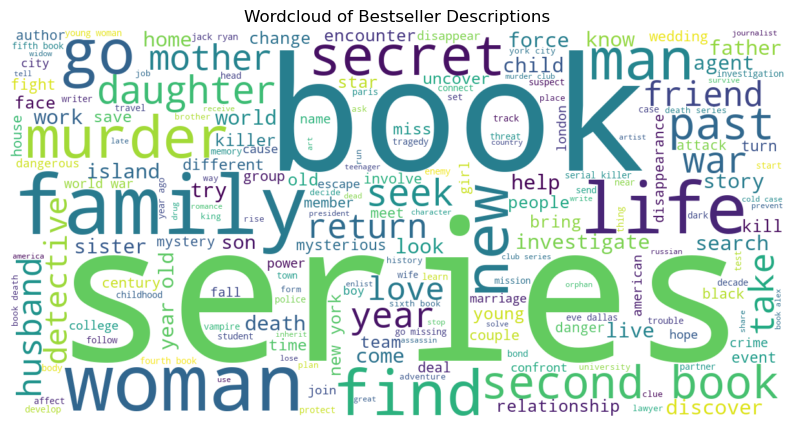

In [58]:
# original text
all_text = " ".join(unique_df["clean_description"])
wc = WordCloud(width=1200, height=600, background_color="white").generate(all_text)

# visualization
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Bestseller Descriptions")
plt.show()

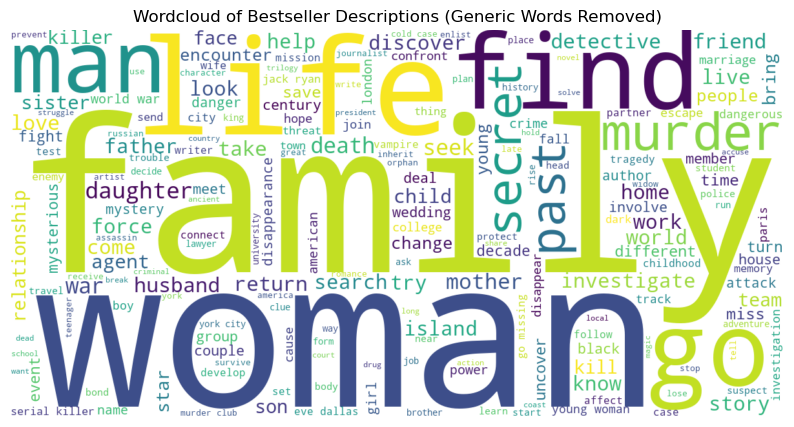

In [59]:
# generic unigrams
remove_words = {
    "book", "series", "new", "year", "old",
    "second", "fourth", "fifth", "sixth"
}

# generic bigrams
remove_phrases = [
    "second book",
    "fourth book",
    "fifth book",
    "sixth book",
    "year old",
    "year ago"
]

text = " ".join(unique_df["clean_description"])

# remove multi-word generic phrases
for phrase in remove_phrases:
    text = text.replace(phrase, " ")

# remove single-word generic terms
filtered_words = [
    w for w in text.split()
    if w not in remove_words
]

filtered_text = " ".join(filtered_words)

# word cloud visualization
wc_clean = WordCloud(width=1200, height=600, background_color="white").generate(filtered_text)

plt.figure(figsize=(10, 6))
plt.imshow(wc_clean, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Bestseller Descriptions (Generic Words Removed)")
plt.show()

* With generic, "noise" words removed, we have a better grasp of dominant themes. Family and woman look like the most common topics, while other expected genre indicators like murder, death, life, love, detective, past, etc are more visible.

* However, we will continue our analysis with the original text so as to not underestimate the prevalence of series fiction.

## TF-IDF Analysis

* Next, calculating the tf-idf score provides perspective on characteristic description words due to its down-weight of extremely common terms, and up-weight of unique words. 

In [60]:
# tf-idf score
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=5)
X = tfidf.fit_transform(unique_df['clean_description'])
feature_names = tfidf.get_feature_names_out()

# compute mean tf-idf score for each term
mean_scores = np.array(X.mean(axis=0)).flatten()
tfidf_df = pd.DataFrame({'term': feature_names, 'score': mean_scores}).sort_values('score', ascending=False)

top_terms = tfidf_df.head(15)
top_terms

,term,score
58,book,0.044242
625,series,0.043629
253,family,0.024460
765,woman,0.023665
402,life,0.022068
774,year,0.017793
470,new,0.017760
301,go,0.016882
751,war,0.016531
456,murder,0.016117


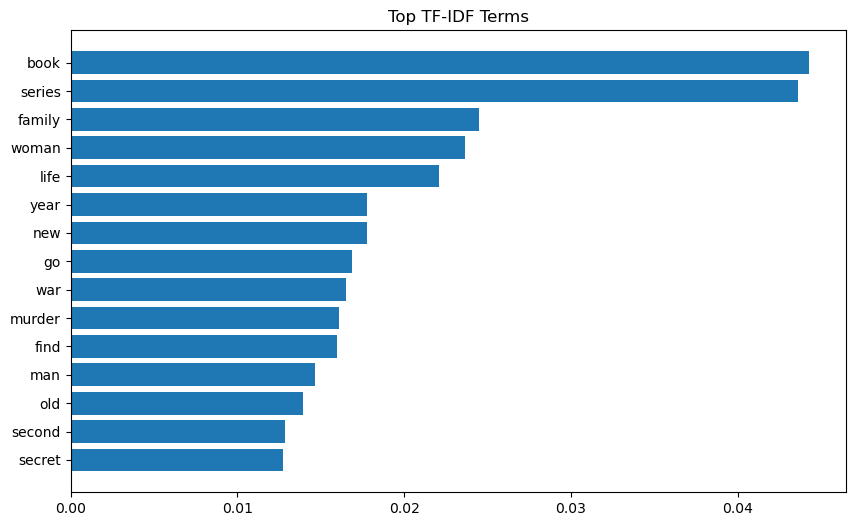

In [61]:
# visualize
plt.figure(figsize=(10,6))
plt.barh(top_terms["term"], top_terms["score"])
plt.gca().invert_yaxis()
plt.title("Top TF-IDF Terms")
plt.show()

* Our tf-idf findings support our frequency analysis findings. 

## LDA Topic Modelng

* In order to identify clusters of themes across bestseller descriptions, we will utilize LDA (Latent Dirichlet Allocation) topic modeling. I chose this model for its easy interpretability and common use as a baseline for topic analysis.

In [62]:
NUM_TOPICS = 15
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, learning_method='batch', random_state=42, max_iter=10)
lda.fit(X)

# function to display topics
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append((topic_idx, top_features))
        print(f"Topic {topic_idx}: "+', '.join(top_features))
    return topics

topics = display_topics(lda, feature_names, 12)

Topic 0: second, second book, series, book, city, war, world, detective, rapp, warrior, fate, set
Topic 1: book, series, deadly, hunter, stephanie, plum, magic, dragon, sorrengail, violet sorrengail, violet, massacre
Topic 2: missing, go, encounter, family, go missing, case, secret, old, decade, father, daughter, century
Topic 3: book, man, ryan, series, jack, jack ryan, ago, year ago, investigate, woman, man series, young
Topic 4: collection, book, series, fourth, fourth book, story, poem, group, prevent, collection poem, author, sister
Topic 5: death, year, year old, woman, old, mother, eve, sister, love, eve dallas, dallas, past
Topic 6: life, different, family, live, chief, start, solve, book, rise, secret, question, series
Topic 7: life, killer, serial, serial killer, tell, turn, form, tragedy, new, assassin, woman, quest
Topic 8: vampire, try, near, uncover, accuse, longmire, real, kidnap, final, america, world, trilogy
Topic 9: miss, family, home, husband, follow, child, wife, j

* The generated topics are expected due to their similarity with existing genres. For example, Topic 1 seems associated with the fantasy genre, Topic 7 with mystery/ thrillers, Topic 9 with family drama, and Topic 2 with detective stories. 

In [63]:
# assign dominant topic to each book
topic_dist = lda.transform(X)
unique_df['dominant_topic'] = topic_dist.argmax(axis=1)
unique_df['dominant_topic'].value_counts().sort_index()

dominant_topic
0      94
1      56
2     134
3      82
4     110
5     136
6     104
7      86
8      58
9     109
10     85
11     73
12     64
13     84
14     91
Name: count, dtype: int64

* Topic 2 (missing, go, encounter, family, go missing, case, secret, old, decade, father, daughter, century) and Topic 5 (death, year, year old, woman, old, mother, eve, sister, love, eve dallas, dallas, past) are most common among bestseller book descriptions.

* If I were to speculate, the high-emotion, relationship-driven suspense of these two topics appeals to a broad audience.

In [64]:
# topic summary, sorted by avg weeks on list
topic_summary = unique_df.groupby('dominant_topic').agg(
    count=('isbn13', 'count'),
    avg_rank=('rank', 'mean'),
    avg_weeks=('weeks_on_list', 'mean')
).sort_values('avg_weeks', ascending=False)

topic_summary

,count,avg_rank,avg_weeks
dominant_topic,,,
1,56,5.250000,4.589286
14,91,7.076923,1.879121
5,136,7.014706,1.669118
9,109,6.733945,1.623853
10,85,7.635294,1.494118
12,64,7.453125,1.421875
11,73,6.273973,1.328767
6,104,6.259615,1.096154
13,84,7.000000,1.083333


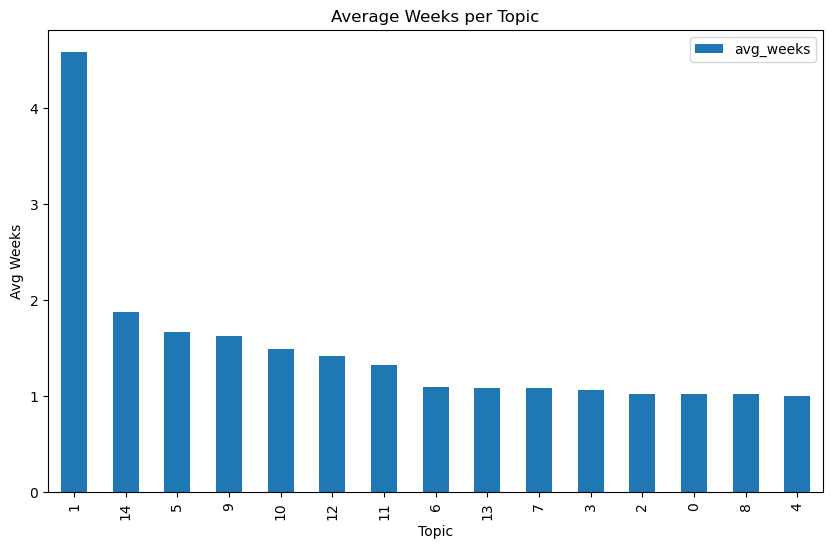

In [65]:
# visualization
topic_summary[["avg_weeks"]].plot(kind="bar", figsize=(10,6))
plt.title("Average Weeks per Topic")
plt.ylabel("Avg Weeks")
plt.xlabel("Topic")
plt.show()

* Topic 1 (second, second book, series, book, city, war, world, detective, rapp, warrior, fate, set) has the highest longevity of 4.6 average weeks, more than double the longevity of the next highest topic. At the same time, Topic 1 sees the lowest frequency and average ranking on the bestsellers list. 

* Topic 1 is dominated by series fiction, which have strong brand loyalty and thus stable longevity. The lower ranking could perhaps indicate that books in a series rarely debut at a high rank, and instead trades ranking with stable longevity and loyal fanbases.

## Sentiment Analysis

* Lastly, I wanted to determine whether tone or emotional valence correlates with commercial success. From experience, my guess is that darker themes will be associated with greater success. I will use VADER to assign sentiment scores due to its effectiveness with short descriptive text, and common usage. 

In [66]:
sia = SentimentIntensityAnalyzer()
unique_df['sentiment_compound'] = unique_df['clean_description'].apply(lambda x: sia.polarity_scores(x)['compound'])
sent_by_topic = unique_df.groupby('dominant_topic')['sentiment_compound'].mean().sort_values()

sent_by_topic

dominant_topic
11   -0.374330
3    -0.239022
14   -0.216681
7    -0.205102
5    -0.200150
8    -0.188526
0    -0.177829
10   -0.173574
13   -0.171915
9    -0.161798
6    -0.139818
2    -0.138644
4    -0.138380
12   -0.124016
1    -0.106996
Name: sentiment_compound, dtype: float64

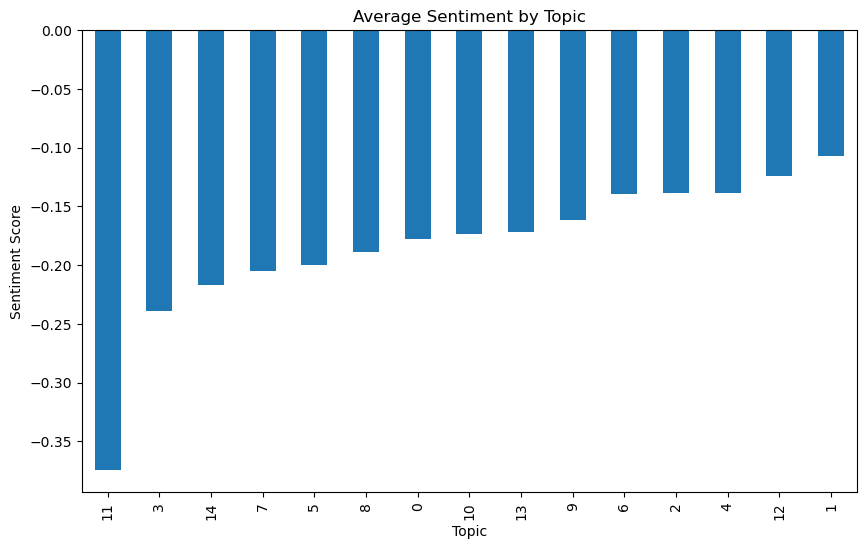

In [67]:
# visualization
sent_by_topic.sort_values().plot(kind="bar", figsize=(10,6))
plt.title("Average Sentiment by Topic")
plt.ylabel("Sentiment Score")
plt.xlabel("Topic")
plt.show()

* All topics have a negative score, which is expected since book conflicts and tensions often thrive on schadenfreude. For example, popular fiction archetypes include crime thrillers, domestic suspense, action thrillers, dark literary fiction, etc. So, it seems that readers are drawn to stories with danger and high stakes.

* Topic 11 (north, murder, series, book, partner, family, club, reacher, north carolina, murder club, club series, explore) has the lowest score of -0.37. This makes sense given the dark language in Topic 11 (murder, murder club).

# Summary of Insights

* This analysis explored what types of stories dominate NYT bestselling hardcover fiction through NLP tools including frequency analysis, TF-IDF, topic modeling, and sentiment scoring. Across methods, several patterns emerge consistently:

1. The NYT bestseller list is dominated by series fiction. Topic 1 (series-driven books) has the longest average lifespan on the list, likely due to loyal fanbases, consistent releases, and strong author branding. These books hit lower rankings on average but maintain weeks of stable performance.

2. Strong female-led narratives are common in the modern bestseller. Words such as woman, mother, sister, daughter appear at  high rates, indicating a market shaped by stories about women and for women, echoing purchasing demographics.

3. The most common themes reflect domestic suspense, trauma, family, and identity. Topics 2 and 5, which revolve around missing persons, family conflict, generational secrets, and emotional trauma, are the most common topics overall.

4. Negative sentiment is common on the NYT bestseller list. Every topic cluster shows negative sentiment, indicating that narratives with dark themes are popular across bestselling books.


In [68]:
# dataframe for visualization
topic_terms = {}
for topic_idx, top_words in topics:
    topic_terms[topic_idx] = top_words

topic_terms_df = pd.DataFrame.from_dict(topic_terms, orient='index').transpose()
topic_terms_df.columns = [f'Topic_{i}' for i in topic_terms_df.columns]
topic_terms_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14
0,second,book,missing,book,collection,death,life,life,vampire,miss,york,north,stone,alex,lawyer
1,second book,series,go,man,book,year,different,killer,try,family,new york,murder,force,series,young
2,series,deadly,encounter,ryan,series,year old,family,serial,near,home,new,series,agent,book,woman
3,book,hunter,family,series,fourth,woman,live,serial killer,uncover,husband,town,book,fight,cross,young woman
4,city,stephanie,go missing,jack,fourth book,old,chief,tell,accuse,follow,fifth,partner,war,put,return
5,war,plum,case,jack ryan,story,mother,start,turn,longmire,child,fifth book,family,book,seek,kill
6,world,magic,secret,ago,poem,eve,solve,form,real,wife,small,club,series,help,new
7,detective,dragon,old,year ago,group,sister,book,tragedy,kidnap,joe,york city,reacher,mission,king,seventh
8,rapp,sorrengail,decade,investigate,prevent,love,rise,new,final,search,city,north carolina,barrington,book alex,seventh book
9,warrior,violet sorrengail,father,woman,collection poem,eve dallas,secret,assassin,america,murder,series,murder club,barrington series,dangerous,long


In [70]:
# save
os.makedirs('../../data/results', exist_ok=True)
df.to_csv('../../data/results/bestsellers_nlp_topics_sentiment.csv', index=False)
topic_summary.to_csv('../../data/results/topic_summary.csv')
tfidf_df.head(200).to_csv('../../data/results/top_tfidf_terms.csv', index=False)
print('Saved results to ../../data/results/')

Saved results to ../../data/results/
